<a href="https://colab.research.google.com/github/NazaninShafiabadi/ML4NLP/blob/main/SHAFIABADI_M2_convolutions_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

M2 project : Convolutions and character embeddings
======================

The project aims to predict the language from which a character sequence comes from. This is done with surnames and it involves a dozen of languages.

Data download & description
---------------------

In [ ]:
from urllib.request import urlretrieve

urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.train','name2lang.train')
urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.valid','name2lang.valid')

#Prints the beginning of the valid set
istream = open('name2lang.valid')
for idx, line in enumerate(istream):
  print(line.strip())
  if idx >=20:
    break
istream.close()


Barros, Portuguese
Campos, Portuguese
D'cruz, Portuguese
Henriques, Portuguese
Machado, Portuguese
Silva, Portuguese
Torres, Portuguese
Ahearn, Irish
Aonghus, Irish
Brady, Irish
Cearbhall, Irish
Flann, Irish
Kavanagh, Irish
Maguire, Irish
Mcmahon, Irish
Mcneil, Irish
Monahan, Irish
Muirchertach, Irish
Mullen, Irish
O'Connell, Irish
O'Grady, Irish


First exercise : data preprocessing (3pts)
---
The first exercise amounts to create encodings from integers to strings and from strings to integers.

In [ ]:
from typing_extensions import DefaultDict
def vocabulary(filename,char_vocab,pad_token='<pad>'):
    """
    Args:
      filename (str)    : the name of the file
      char_vocab (bool) : selects if we extact char symbols  or language codes
      pad_token(str)    : the value of the pad symbol
    """
    #char_vocab is a boolean flag that tells if we extract char symbols or language codes

    #TODO : return the two encoding maps idx2sym and sym2idx as a couple
    idx2sym = {0: pad_token}
    sym2idx = {pad_token: 0}

    # read file (dataset will be a list of 'surname, language' pairs)
    with open(filename, 'r', encoding='utf-8') as file:
      dataset = [line.strip() for line in file]

    for pair in dataset:
      if ', ' in pair:
        # tokenize text
        surname, lang = pair.split(', ')
        if char_vocab:
          tokens = [char for char in surname]
        else:
          tokens = [lang]

      # populate encoding maps
      for token in tokens:
        if token not in sym2idx:
          sym2idx[token] = len(idx2sym)
          idx2sym[len(idx2sym)] = token

    return (idx2sym, sym2idx)

In [ ]:
vocabulary('name2lang.valid', char_vocab=True)

({0: '<pad>',
  1: 'B',
  2: 'a',
  3: 'r',
  4: 'o',
  5: 's',
  6: 'C',
  7: 'm',
  8: 'p',
  9: 'D',
  10: "'",
  11: 'c',
  12: 'u',
  13: 'z',
  14: 'H',
  15: 'e',
  16: 'n',
  17: 'i',
  18: 'q',
  19: 'M',
  20: 'h',
  21: 'd',
  22: 'S',
  23: 'l',
  24: 'v',
  25: 'T',
  26: 'A',
  27: 'g',
  28: 'y',
  29: 'b',
  30: 'F',
  31: 'K',
  32: 't',
  33: 'O',
  34: 'G',
  35: 'R',
  36: 'f',
  37: ' ',
  38: 'E',
  39: 'x',
  40: 'L',
  41: 'N',
  42: 'P',
  43: 'U',
  44: 'V',
  45: 'Z',
  46: 'w',
  47: 'Q',
  48: 'J',
  49: 'k',
  50: 'j',
  51: 'W',
  52: 'I',
  53: 'Y'},
 {'<pad>': 0,
  'B': 1,
  'a': 2,
  'r': 3,
  'o': 4,
  's': 5,
  'C': 6,
  'm': 7,
  'p': 8,
  'D': 9,
  "'": 10,
  'c': 11,
  'u': 12,
  'z': 13,
  'H': 14,
  'e': 15,
  'n': 16,
  'i': 17,
  'q': 18,
  'M': 19,
  'h': 20,
  'd': 21,
  'S': 22,
  'l': 23,
  'v': 24,
  'T': 25,
  'A': 26,
  'g': 27,
  'y': 28,
  'b': 29,
  'F': 30,
  'K': 31,
  't': 32,
  'O': 33,
  'G': 34,
  'R': 35,
  'f': 36,
  ' ': 37,

In [ ]:
def pad_sequence(sequence,pad_size,pad_token):
  #returns a list with additional pad tokens to match pad_size if needed
  return sequence + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap):
  #we ignore chars not seen in train set
  #charseq is a sequence of chars
  return [encodingmap[char] for char in charseq if char in encodingmap]

def decode_sequence(idxseq,decodingmap):
  #idxseq is a list of integers
  return [decodingmap[idx] for idx in idxseq]

Second exercise : data generator (2pt)
------------

The data generator aims to deliver efficiently well formed batches of data to the model.

In [ ]:
def read_dataset(filename,input_symbols):
    #reads from a raw datafile, either the surnmaes if input_symbols is True otherwise it reads the language
    symbols = []
    istream = open(filename)
    for line in istream:
      if line and not line.isspace():
        word,lang = line.split(',')
        symbol = list(word.strip()) if input_symbols else lang.strip()
        symbols.append(symbol)
    istream.close()
    return symbols


In [ ]:
from random import shuffle

class DataGenerator:

      def __init__(self, filename, parentgenerator=None, pad_token='<pad>'):

           self.pad_token = pad_token
           if parentgenerator is not None: #Reuse the encodings of the parent if specified
             self.input_idx2sym,self.input_sym2idx     = parentgenerator.input_idx2sym,parentgenerator.input_sym2idx
             self.output_idx2sym,self.output_sym2idx   = parentgenerator.output_idx2sym,parentgenerator.output_sym2idx
           else:
             #######################################
             self.input_idx2sym,self.input_sym2idx     = vocabulary(filename,True)  ### fill it !
             self.output_idx2sym,self.output_sym2idx   = vocabulary(filename,False) ### fill it !
             ####################################
           self.X = read_dataset(filename,True)
           self.Y = read_dataset(filename,False)

      def generate_batches(self,batch_size):

              assert(len(self.X) == len(self.Y))

              N     = len(self.X)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.X[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.X[idx]) for idx in batch_idxes)
                 Xpad        = [pad_sequence(self.X[idx],batch_len,self.pad_token)  for idx in batch_idxes]
                 seqX        = [code_sequence(x,self.input_sym2idx) for x in Xpad]
                 seqY        = [self.output_sym2idx[self.Y[idx]] for idx in batch_idxes]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size


1. shuffle(idxes): This line randomizes the order of the data to prevent any element of bias in the data’s sequence from affecting the learning process.

2. idxes.sort(key=lambda idx: len(self.X[idx])): After shuffling, this line sorts the data based on sequence length (from shortest to longest). Sorting is done because it’s generally more efficient to process shorter sequences first and longer ones later. It can also help with better GPU memory utilization as similar length sequences can be processed together, reducing the amount of padding needed.

Third exercise : Implement the word embedding submodule (5pts)
-----
This exercise amounts to implement a pytorch submodule that takes as input a sequence of char indexes and outputs the word embedding corresponding for the sequence.

The module contains no training method and is meant to be used in a larger network. Its use is quite similar to `nn.Embedding`




In [ ]:
import torch
import torch.nn as nn

class CharConvolution(nn.Module):

      def __init__(self,windowK,chars_vocab_size,input_embedding_size,output_embedding_size,padding_idx = None):

          super(CharConvolution, self).__init__()
          #####################################
          #Initialize and allocate an embeddings class and the Conv1d class
          #####################################
          self.embeddings = nn.Embedding(chars_vocab_size, input_embedding_size, padding_idx=padding_idx)
          self.convlayer = nn.Conv1d(input_embedding_size, output_embedding_size, windowK, padding=padding_idx)

      def forward(self,xinput):
          #####################################
          #Implement the forward method, taking an input of the form [batch,seq]
          #and return the max pooled result
          ######################################

          # embeds the input
          x = self.embeddings(xinput) # shape: (batch, seq, input_embed_size)

          # transposes the last two dimensions to match the expected input shape of convlayer
          x = x.transpose(1,2)  # shape: (batch, input_embed_size, seq)

          # applying the convolution over the embedded vectors
          x = self.convlayer(x)  # shape: (batch, output_embed_size, seq)

          # applying a max pooling over the last dimension to get the final output
          pool = nn.MaxPool1d(x.size(-1))
          return pool(x).squeeze(-1)  # shape: (batch, output_embed_size)

Fourth Exercise : predict the target language (10pts)
-------
In this exercise, we aim to predict the target language from a word char embedding. You will implement for the `LanguageIdentifier` class:
* A forward function: the function takes as input a char index tensor and returns a vector of prediction for each word
* A train function: the function trains the model on the full dataset (with early stopping)
* A predict function: the function takes a test corpus (a list of words)
and predicts the language. The function outputs its results in textual form. Each word is printed on the same line as its predicted class.

Once implemented you are expected to search for hyperparameters in the main program.






In [ ]:
import torch.optim as optim

class LanguageIdentifier(nn.Module):

    def __init__(self,datagenerator,window_size,char_embedding_size,word_embedding_size):
      super(LanguageIdentifier, self).__init__()
      invocab_size   = len(datagenerator.input_idx2sym)
      outvocab_size  = len(datagenerator.output_idx2sym)
      pad_idx        = datagenerator.input_sym2idx[datagenerator.pad_token]
      self.charE     = CharConvolution(window_size,invocab_size,char_embedding_size,word_embedding_size,padding_idx = pad_idx)
      self.output    = nn.Linear(word_embedding_size,outvocab_size)

    def load(self,filename):
        self.load_state_dict(torch.load(filename))


    def forward(self,xinput):
      #########################
      #takes as input a tensor of the form [batch,seq]
      #and returns a vector of predictions for the language
      word_embeddings = self.charE(xinput)  # shape: (batch_size, word_embedding_size)
      return self.output(word_embeddings)   # shape: (word_embedding_size, outvocab_size)
      #########################

    def train_model(self,traingenerator,validgenerator,epochs,batch_size,device='cpu',learning_rate=0.001):

      self.minloss = 10000000 #the minimal validation loss found so far for an epoch
      ###########################
      #TODO Implement the training function, save the model with minimum loss
      device = torch.device(device)
      loss_fnc = nn.CrossEntropyLoss()
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)

      # Lists to store training and validation accuracies and the average validation loss at each epoch (for plotting)
      self.train_accuracies = []
      self.valid_accuracies = []
      self.avg_losses = []

      # Variables needed for early stopping
      patience = 3  # num of epochs to wait before stopping training
      n_consecutive_epochs = 0

      for epoch in range(epochs):
        batch_accuracies = []
        batch_losses     = []
        batch_sizes      = []

        self.train()  # sets the model in training mode
        for (seqX,seqY) in traingenerator.generate_batches(batch_size):
          X = torch.LongTensor(seqX).to(device)
          Y = torch.LongTensor(seqY).to(device)

          optimizer.zero_grad() # makes sure the gradient is reinitialised to zero
          Yhat = self.forward(X)
          loss = loss_fnc(Yhat, Y)
          loss.backward()
          optimizer.step()
          Ypred = torch.argmax(Yhat, dim=1)
          acc = float(torch.sum(Ypred == Y))

          batch_losses.append(loss.item())
          batch_accuracies.append(acc)
          batch_sizes.append(len(Y))

        avg_train_acc = sum(batch_accuracies) / sum(batch_sizes)
        avg_train_loss = sum(batch_losses) / len(batch_losses)
        print(f'[train][epoch {epoch}] mean loss: {avg_train_loss}, mean acc: {avg_train_acc}')

        # Add the average train accuracy for this epoch
        self.train_accuracies.append(avg_train_acc)

        # Validate the model & save the model with minimum validation loss
        # (by calling the validate method with save_min_model=True, the model with minimum validation loss will be saved to 'names_params.pt')
        self.eval()  # sets the model in evaluation mode
        valid_loss, valid_acc = self.validate(validgenerator, batch_size, device, save_min_model=True)

        # Add the average validation accuracy and loss for this epoch
        self.valid_accuracies.append(valid_acc)
        self.avg_losses.append(valid_loss)

        # Check for early stopping
        if valid_loss <= self.minloss:
          self.minloss = valid_loss
          n_consecutive_epochs = 0  # reset the counter
        else:
          n_consecutive_epochs += 1

        # If no improvement for 'patience' consecutive epochs, stop training
        if n_consecutive_epochs == patience:
          print(f"Early stopping after {patience} epochs without improvement.")
          break
      ###########################

    def predict(self,datagenerator,batch_size,device):
        ##########################
        #TODO implement a prediction function that returns the class with highest score for each word in the batch
        device = torch.device(device)
        self.eval()  # sets the model in evaluation mode
        predictions = []

        for (seqX,_) in datagenerator.generate_batches(batch_size):
          X = torch.LongTensor(seqX).to(device)
          Yhat = self.forward(X)
          Ypred = torch.argmax(Yhat, dim=1) # list of classes with highest score for each word in the batch
          predictions.append(Ypred)

          pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
          for i in range(len(X)):
            # joining the letters of the surnames (excluding the pad token)
            word = ''.join([datagenerator.input_idx2sym[idx.item()] for idx in X[i] if idx.item() is not pad_idx])
            lang = datagenerator.output_idx2sym[Ypred[i].item()]
            print(f'{word}, {lang}')

        return predictions
        ##########################

    def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False):
        #This function cannot be modified

        batch_accurracies = []
        batch_losses      = []
        batch_sizes       = []

        device    = torch.device(device)
        loss_fnc  = nn.CrossEntropyLoss()

        for (seqX,seqY) in datagenerator.generate_batches(batch_size):

              with torch.no_grad():
                  X    = torch.LongTensor(seqX).to(device)
                  Y    = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)
                  loss = loss_fnc(Yhat,Y)
                  Ypred = torch.argmax(Yhat,dim=1)
                  acc   = float(torch.sum(Ypred == Y))

                  batch_losses.append(loss.item())
                  batch_accurracies.append(acc)
                  batch_sizes.append(len(Y))

        valid_loss = sum(batch_losses) / len(batch_losses)
        print('[valid]  mean loss = %f, mean acc = %f'%( valid_loss , sum(batch_accurracies)/sum(batch_sizes)))

        # I took the liberty to add save_min_model because it wasn't being used
        if save_min_model and valid_loss < self.minloss:
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'names_params.pt')

        return valid_loss , sum(batch_accurracies)/sum(batch_sizes) # added this line to return the validation loss and accuracy


Main program. You are expected to search for hyperparameters:

In [ ]:
traing = DataGenerator('name2lang.train')
validg = DataGenerator('name2lang.valid',parentgenerator=traing)

model = LanguageIdentifier(traing,2,32,512)
model.train_model(traing,validg,25,128)

[train][epoch 0] mean loss: 1.339388216574361, mean acc: 0.6027006937561943
[valid]  mean loss = 1.519519, mean acc = 0.542504
[train][epoch 1] mean loss: 1.0633229913674003, mean acc: 0.693384539147671
[valid]  mean loss = 1.151437, mean acc = 0.647604
[train][epoch 2] mean loss: 0.8818358668661493, mean acc: 0.7438057482656095
[valid]  mean loss = 0.992945, mean acc = 0.687790
[train][epoch 3] mean loss: 0.7589207067499011, mean acc: 0.7767591674925669
[valid]  mean loss = 0.885720, mean acc = 0.735188
[train][epoch 4] mean loss: 0.6753601323901199, mean acc: 0.7978815659068385
[valid]  mean loss = 0.819386, mean acc = 0.741370
[train][epoch 5] mean loss: 0.6191264450784744, mean acc: 0.8125619425173439
[valid]  mean loss = 0.749768, mean acc = 0.772798
[train][epoch 6] mean loss: 0.5647754168475237, mean acc: 0.8282333994053518
[valid]  mean loss = 0.712072, mean acc = 0.779495
[train][epoch 7] mean loss: 0.5291138464130285, mean acc: 0.8361620416253717
[valid]  mean loss = 0.689837

In [ ]:
'''Function to plot the evolution of training loss & accuracy across epochs'''

import matplotlib.pyplot as plt

def plot(losses, train_acc, valid_acc):
  min_loss, min_idx = min((val, idx) for idx, val in enumerate(losses))
  print(f"Min Loss: {min_loss}   Epoch {min_idx + 1}")

  max_valid_acc, max_idx_valid = max((val, idx) for idx, val in enumerate(valid_acc))
  print(f"Max Validation Accuracy: {max_valid_acc}   Epoch {max_idx_valid + 1}")

  max_train_acc, max_idx_train = max((val, idx) for idx, val in enumerate(train_acc))
  print(f"Max Training Accuracy: {max_train_acc}   Epoch {max_idx_train + 1}")

  plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Loss')
  plt.plot(range(1, len(valid_acc) + 1), valid_acc, marker='o', label='Validation Accuracy')
  plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label='Training Accuracy')
  plt.title('Loss & Accuracy Evolution Over Epochs')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True, linestyle='--')
  plt.show()

Min Loss: 0.6066100581083447   Epoch 13
Max Validation Accuracy: 0.8124678001030397   Epoch 13
Max Training Accuracy: 0.8891228939544104   Epoch 16


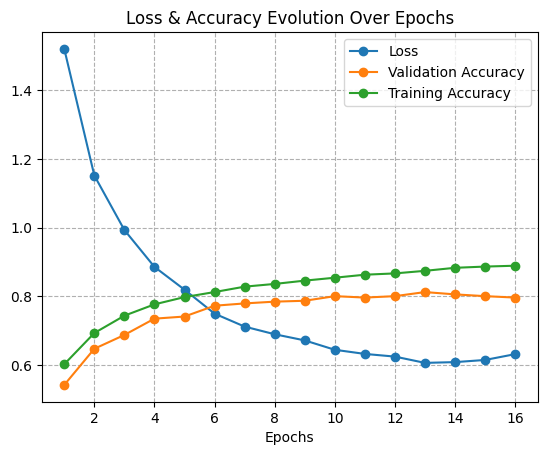

In [ ]:
plot(model.avg_losses, model.train_accuracies, model.valid_accuracies)

In [ ]:
predictions = model.predict(validg, 128, device='cpu')

Vu, Russian
Ba, Arabic
Ha, Arabic
Ko, Dutch
Ba, Arabic
La, English
Ho, English
Baz, Arabic
Guo, Chinese
Tow, English
Bag, Russian
Ito, Japanese
Sai, Arabic
Que, Spanish
Abt, Russian
Opp, English
Isa, Arabic
Hew, German
Sun, Japanese
Yim, Russian
Suk, Japanese
Loi, Russian
Mas, Arabic
See, Dutch
Seo, Japanese
Val, Russian
Kau, Japanese
San, Japanese
Mac, Scottish
Tos, Japanese
Baz, Arabic
Loh, Russian
Fin, Italian
Pho, English
Ven, Dutch
Lut, Russian
Bir, Russian
Isa, Arabic
Yan, Chinese
Ens, Russian
Khu, Korean
Kieu, Japanese
Rory, English
Farr, English
Nave, English
Vild, Russian
Venn, Dutch
Shea, Chinese
Said, Arabic
Hizh, Russian
Hase, Japanese
Imai, Japanese
Cham, Arabic
Foht, English
Gall, English
Rook, Korean
Rose, English
Ware, English
Fogg, English
Kill, English
Voll, Spanish
Baba, Arabic
Hand, Arabic
Cham, Arabic
Burn, English
Cham, Arabic
Seok, Japanese
Baba, Arabic
Abel, Russian
Tait, Russian
Kriz, Polish
Nijo, Japanese
Seer, German
Kalb, Arabic
Nott, English
Beer, German
Ax

In [ ]:
predictions

In [ ]:
!pip install ray

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from ray import tune, train
from ray.tune import CLIReporter

traing = DataGenerator('name2lang.train')
validg = DataGenerator('name2lang.valid', parentgenerator=traing)

def hyperparameter_search(config):
  model = LanguageIdentifier(traing, 2, config['char_embedding_size'], config['word_embedding_size']).to(device)
  optimizer = optim.Adam(model.parameters(), lr=config['lr'])
  loss_fn = nn.CrossEntropyLoss()

  # Variables needed for early stopping
  min_val_loss = float('inf')  # (initializing with the highest possible value)
  patience = 3  # num of epochs to wait before stopping training
  n_consecutive_epochs = 0

  # Training
  for epoch in range(config['epochs']):
    for (seqX,seqY) in traing.generate_batches(config['batch_size']):
      X = torch.LongTensor(seqX).to(device)
      Y = torch.LongTensor(seqY).to(device)

      optimizer.zero_grad() # makes sure the gradient is reinitialised to zero
      Yhat = model.forward(X)
      loss = loss_fn(Yhat, Y)
      loss.backward()
      optimizer.step()
      Ypred = torch.argmax(Yhat, dim=1)
      acc = float(torch.sum(Ypred == Y))

    # Validate the model
    model.eval()
    valid_loss, valid_acc = model.validate(validg, config['batch_size'], device, save_min_model=False)

    train.report({'validation_accuracy': valid_acc, 'validation_loss': valid_loss})

    print(f'[valid][epoch {epoch}] mean loss: {valid_loss}, mean acc: {valid_acc}')


    # Check for early stopping
    if valid_loss <= min_val_loss:
      min_val_loss = valid_loss
      n_consecutive_epochs = 0  # Reset the counter
    else:
      n_consecutive_epochs += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if n_consecutive_epochs == patience:
      print(f"Early stopping after {n_consecutive_epochs} epochs without improvement.")
      break


In [ ]:
# Defining hyperparameter grid
config = {
    'lr': tune.choice([0.01, 0.001, 0.0001]),
    'char_embedding_size': tune.choice([32, 52, 72]),
    'word_embedding_size': tune.choice([128, 256, 512]),
    'epochs': tune.choice([25, 35, 40]),
    'batch_size': 128
    }

# Perform the search
analysis = tune.run(
    hyperparameter_search,
    config=config,
    num_samples=10,  # num of configurations to try
    progress_reporter=CLIReporter(max_report_frequency=60),  # report progress every 60secs
    metric='validation_accuracy',
    resources_per_trial={'cpu': 1, 'gpu': 1} if device == 'cuda' else {'cpu': 2, 'gpu': 0}
    )

2023-10-27 21:11:13,819	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-27 21:11:17,602	INFO tune.py:228 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-10-27 21:11:17,611	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-10-27 21:11:17,789	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-10-27 21:11:17,794	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2023-10-27 21:11:17,801	WARNING tune.py:997 -- AIR_VERBOSITY is set, ignoring p

+------------------------------------------------------------------------------+
| Configuration for experiment     hyperparameter_search_2023-10-27_21-11-17   |
+------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                       |
| Scheduler                        FIFOScheduler                               |
| Number of trials                 10                                          |
+------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/hyperparameter_search_2023-10-27_21-11-17

Trial status: 10 PENDING
Current time: 2023-10-27 21:11:20. Total running time: 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------+
| Trial name                          status         lr     char_embedding_size     word_embedding

In [ ]:
best_trial = analysis.get_best_trial(metric='validation_accuracy', mode="max")

best_hyperparameters = best_trial.config
best_hyperparameters

{'lr': 0.0001,
 'char_embedding_size': 72,
 'word_embedding_size': 512,
 'epochs': 40,
 'batch_size': 128}

In [ ]:
# Instantiate and train the model with the best hyperparameters
lr, char_embed_size, word_embed_size, epochs, batch_size = best_hyperparameters.values()
window_size = 2
model = LanguageIdentifier(traing,window_size,char_embed_size,word_embed_size)
model.train_model(traing,validg,epochs,batch_size)

[train][epoch 0] mean loss: 1.209809167413261, mean acc: 0.6418483647175421
[valid]  mean loss = 1.375533, mean acc = 0.581144
[train][epoch 1] mean loss: 0.9420265668020473, mean acc: 0.7260282457879088
[valid]  mean loss = 1.015823, mean acc = 0.673364
[train][epoch 2] mean loss: 0.7538957902648318, mean acc: 0.7729806739345887
[valid]  mean loss = 0.872840, mean acc = 0.723854
[train][epoch 3] mean loss: 0.6454101503482015, mean acc: 0.8056243805748265
[valid]  mean loss = 0.760526, mean acc = 0.766615
[train][epoch 4] mean loss: 0.57322472715237, mean acc: 0.8222249752229931
[valid]  mean loss = 0.733611, mean acc = 0.761463
[train][epoch 5] mean loss: 0.514957468898043, mean acc: 0.8416129831516352
[valid]  mean loss = 0.675286, mean acc = 0.778980
[train][epoch 6] mean loss: 0.47209306416197083, mean acc: 0.8515857284440039
[valid]  mean loss = 0.653510, mean acc = 0.784647
[train][epoch 7] mean loss: 0.4346433535482236, mean acc: 0.8617443012884044
[valid]  mean loss = 0.635383,

Min Loss: 0.6185977491550148   Epoch 15
Max Validation Accuracy: 0.8119526017516744   Epoch 15
Max Training Accuracy: 0.9199702675916749   Epoch 18


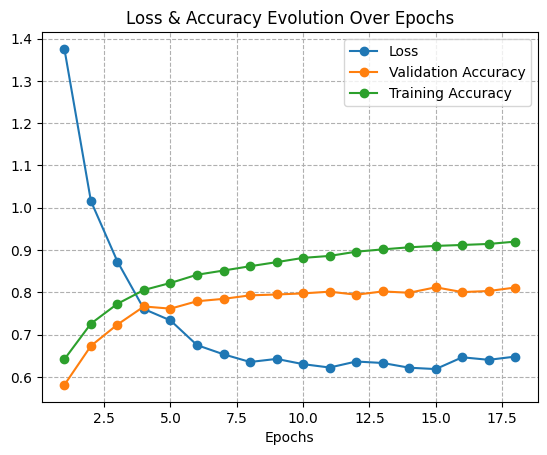

In [ ]:
# Plot the new model
plot(model.avg_losses, model.train_accuracies, model.valid_accuracies)